In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
nltk.download('stopwords')
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')

import os
import json
from tqdm import tqdm
import time

from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForMaskedLM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/'210 Capstone'/PC_Classifier

/content/drive/MyDrive/210 Capstone/PC_Classifier


In [4]:
pwd

'/content/drive/MyDrive/210 Capstone/PC_Classifier'

In [5]:
path = '/content/drive/MyDrive/210 Capstone/PC_Classifier/'

In [6]:
def load_data(path):
  train_df = pd.read_csv(path + 'train_aug_df.csv')
  test_df = pd.read_csv(path + 'test_df.csv')
  val_df = pd.read_csv(path + 'val_df.csv')
  return train_df, val_df, test_df

train_df, val_df, test_df = load_data(path)
print("train data shape: ", train_df.shape)
print("val data shape: ", val_df.shape)
print("test data shape: ", test_df.shape)

train data shape:  (17612, 13)
val data shape:  (2162, 12)
test data shape:  (2162, 12)


### 1. Train data

In [7]:
train_df.head(2)

,Unnamed: 0.1,Unnamed: 0,doc_id,test_category,segment_number,unique_policy_identifier,label,policy_category,segment_details,policy_date,url,policy_chunk,sub_labels
0,0,0,23954.0,test_category_labeling_highlight_upitt,123.0,3708.0,42.0,Other,"{""Other Type"": {""endIndexInSegment"": 276, ""sta...",5/29/15,https://www.allstate.com/about/privacy-stateme...,Please send requests to: Allstate Insurance Co...,['Other Type']
1,1,1,17925.0,test_category_labeling_highlight_fordham_ccccc,117.0,3849.0,15.0,User Choice/Control,"{""Choice Type"": {""selectedText"": ""changing the...",5/11/09,http://www.pbs.org/about/policies/privacy-policy/,changing the settings in your web browser Not ...,"['Choice Type', 'Choice Scope', 'User Type', '..."


In [8]:
train_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [9]:
train_df.head(2)

,doc_id,test_category,segment_number,unique_policy_identifier,label,policy_category,segment_details,policy_date,url,policy_chunk,sub_labels
0,23954.0,test_category_labeling_highlight_upitt,123.0,3708.0,42.0,Other,"{""Other Type"": {""endIndexInSegment"": 276, ""sta...",5/29/15,https://www.allstate.com/about/privacy-stateme...,Please send requests to: Allstate Insurance Co...,['Other Type']
1,17925.0,test_category_labeling_highlight_fordham_ccccc,117.0,3849.0,15.0,User Choice/Control,"{""Choice Type"": {""selectedText"": ""changing the...",5/11/09,http://www.pbs.org/about/policies/privacy-policy/,changing the settings in your web browser Not ...,"['Choice Type', 'Choice Scope', 'User Type', '..."


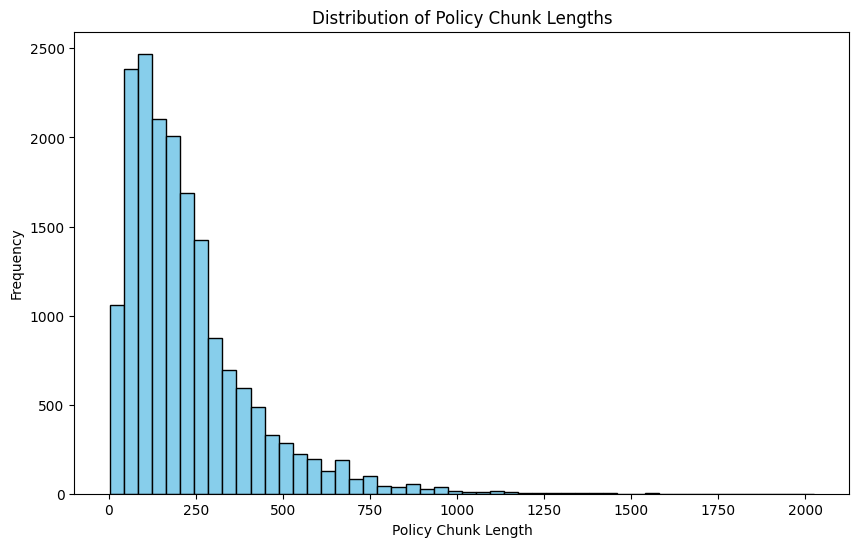

In [10]:
train_df['policy_chunk_length'] = train_df['policy_chunk'].apply(len)

# Plot the distribution
plt.figure(figsize=(10,6))
plt.hist(train_df['policy_chunk_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Policy Chunk Lengths')
plt.xlabel('Policy Chunk Length')
plt.ylabel('Frequency')
plt.show()


In [11]:
from sklearn.preprocessing import LabelEncoder

def prepare_policy_data(train_df, val_df, test_df):
    """
    Prepares the policy dataset for multi-class classification.

    Args:
    - train_df: DataFrame containing the training dataset with columns 'policy_chunk' and 'policy_category'.
    - val_df: DataFrame containing the validation dataset with columns 'policy_chunk' and 'policy_category'.
    - test_df: DataFrame containing the test dataset with columns 'policy_chunk' and 'policy_category'.

    Returns:
    - train_texts, val_texts, test_texts: Lists containing texts for training, validation, and testing.
    - train_labels, val_labels, test_labels: Arrays containing encoded labels for training, validation, and testing.
    - target_names: List of unique labels (policy categories).
    """
    le = LabelEncoder()

    all_labels = pd.concat([train_df['policy_category'], val_df['policy_category'], test_df['policy_category']])
    le.fit(all_labels)

    train_labels = le.transform(train_df['policy_category'])
    val_labels = le.transform(val_df['policy_category'])
    test_labels = le.transform(test_df['policy_category'])

    train_texts = train_df['policy_chunk'].tolist()
    val_texts = val_df['policy_chunk'].tolist()
    test_texts = test_df['policy_chunk'].tolist()

    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, le.classes_

train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, target_names = prepare_policy_data(train_df, val_df, test_df)


In [12]:
print(train_labels[:2])
print(train_texts[:2])
print(len(target_names))

[5 9]
['Please send requests to: Allstate Insurance Company Customer Privacy Inquiries, P.O. Box 40047, Roanoke, VA 24022-0047', 'changing the settings in your web browser Not selected null Not selected cookies']
10


In [13]:
print(len(train_texts))
print(len(val_texts))

17612
2162


In [14]:
np_train_labels = np.asarray(train_labels)
np_val_labels = np.asarray(val_labels)
np_test_labels = np.asarray(test_labels)

In [15]:
model_checkpoint = 'nlpaueb/legal-bert-base-uncased'

legalbert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
legalbert_model = TFAutoModel.from_pretrained(model_checkpoint, from_pt=True)
legalbert_mlm = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint, from_pt=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [16]:
max_seq_length = 300

train_encodings = legalbert_tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_seq_length)
val_encodings = legalbert_tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_seq_length)
test_encodings = legalbert_tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_seq_length)

input_ids_shape = len(train_encodings['input_ids']), len(train_encodings['input_ids'][0])
token_type_ids_shape = len(train_encodings['token_type_ids']), len(train_encodings['token_type_ids'][0])
attention_mask_shape = len(train_encodings['attention_mask']), len(train_encodings['attention_mask'][0])

print(f"Train Input IDs shape: {input_ids_shape}")
print(f"Train Token Type IDs shape: {token_type_ids_shape}")
print(f"Train Attention Mask shape: {attention_mask_shape}")

val_input_ids_shape = len(val_encodings['input_ids']), len(val_encodings['input_ids'][0])
val_token_type_ids_shape = len(val_encodings['token_type_ids']), len(val_encodings['token_type_ids'][0])
val_attention_mask_shape = len(val_encodings['attention_mask']), len(val_encodings['attention_mask'][0])

print("\nValidation Data:")
print(f"Validation Input IDs shape: {val_input_ids_shape}")
print(f"Validation Token Type IDs shape: {val_token_type_ids_shape}")
print(f"Validation Attention Mask shape: {val_attention_mask_shape}")

test_input_ids_shape = len(test_encodings['input_ids']), len(test_encodings['input_ids'][0])
test_token_type_ids_shape = len(test_encodings['token_type_ids']), len(test_encodings['token_type_ids'][0])
test_attention_mask_shape = len(test_encodings['attention_mask']), len(test_encodings['attention_mask'][0])

print("\nTest Data:")
print(f"Test Input IDs shape: {test_input_ids_shape}")
print(f"Test Token Type IDs shape: {test_token_type_ids_shape}")
print(f"Test Attention Mask shape: {test_attention_mask_shape}")


Train Input IDs shape: (17612, 300)
Train Token Type IDs shape: (17612, 300)
Train Attention Mask shape: (17612, 300)

Validation Data:
Validation Input IDs shape: (2162, 300)
Validation Token Type IDs shape: (2162, 300)
Validation Attention Mask shape: (2162, 300)

Test Data:
Test Input IDs shape: (2162, 300)
Test Token Type IDs shape: (2162, 300)
Test Attention Mask shape: (2162, 300)


In [17]:
def compute_sample_weights(df, label_column):
    """
    Compute sample weights for multi-class classification based on class imbalance.

    Parameters:
    - df: pandas DataFrame containing the training data
    - label_column: string name of the DataFrame column containing the single class label

    Returns:
    - sample_weights: numpy array of sample weights where rows correspond to samples
    """
    label_freq = df[label_column].value_counts()

    label_weights = 1 / label_freq

    label_weights /= label_weights.sum()

    label_weight_map = label_weights.to_dict()

    sample_weights = df[label_column].map(label_weight_map).values

    return np.array(sample_weights)

sample_weights = compute_sample_weights(train_df, 'policy_category')

print(sample_weights[:5])


[0.11523021 0.09284512 0.11523021 0.11523021 0.09284512]


In [18]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf

def build_finetune_legalbert(pretrained_model_name_or_path='nlpaueb/legal-bert-base-uncased',
                             num_classes=10,
                             max_length=300,
                             hidden_size=[1024],
                             dropout=0.1,
                             learning_rate=0.00005,
                             from_pt=True):
    """
    Builds and fine-tunes a LegalBERT model for multi-class classification.

    Args:
    - pretrained_model_name_or_path: The pretrained LegalBERT model.
    - num_classes: The number of output classes.
    - max_length: The maximum length of the input sequence.
    - hidden_size: Size of the hidden layers.
    - dropout: Dropout rate.
    - learning_rate: Learning rate for Adam optimizer.
    - from_pt: Load the model from PyTorch.

    Returns:
    - classification_model: Compiled TensorFlow model ready for training.
    """
    tf.keras.backend.clear_session()

    pretrained_LLM = TFAutoModel.from_pretrained(pretrained_model_name_or_path, from_pt=from_pt, output_hidden_states=False, output_attentions=False)

    pretrained_LLM.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    llm_inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

    llm_out = pretrained_LLM(llm_inputs)
    output_token = llm_out.last_hidden_state

    hidden = tf.math.reduce_mean(output_token, axis=1)

    for i, size in enumerate(hidden_size):
        hidden = tf.keras.layers.Dense(size, activation='relu', name=f'hidden_layer_{i}')(hidden)
        hidden = tf.keras.layers.Dropout(dropout)(hidden)

    output_classification = tf.keras.layers.Dense(num_classes, activation='softmax')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[output_classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])


    return classification_model


In [19]:
num_cat = len(target_names)
num_cat

10

In [20]:
legalbert_model = build_finetune_legalbert(pretrained_model_name_or_path='nlpaueb/legal-bert-base-uncased',
                                           num_classes=num_cat,
                                           max_length=300)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [21]:
legalbert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 300)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 300)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['attention_mask[0][0]',      
 )                           ngAndCrossAttentions(last_   40         'input_ids[0][0]']           
                             hidden_state=(None, 300, 7                                       

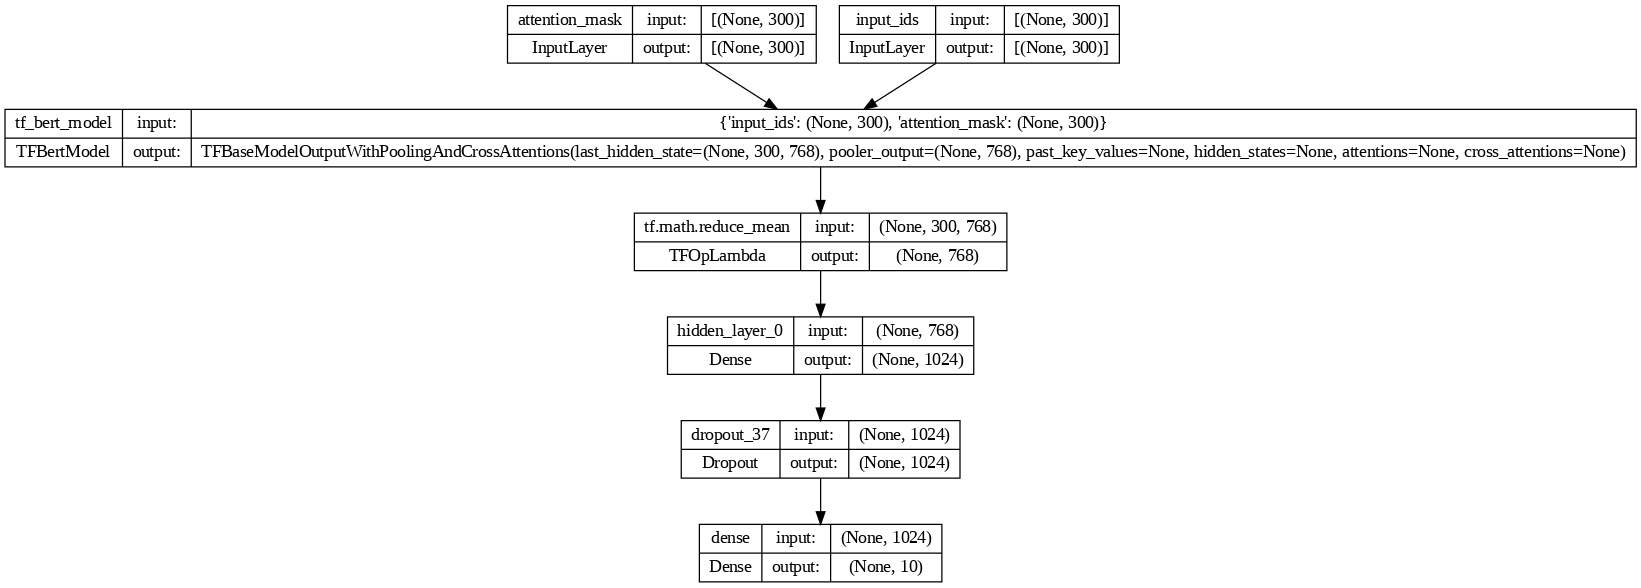

In [22]:
keras.utils.plot_model(legalbert_model, show_shapes=True, show_dtype=False, show_layer_names=True, dpi=90)

In [23]:
print("Length of sample weights:", len(sample_weights))
print("Number of training samples:", len(train_encodings.input_ids))


Length of sample weights: 17612
Number of training samples: 17612


In [24]:
max_seq_length = 300

train_encodings = legalbert_tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors="np")
val_encodings = legalbert_tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors="np")
test_encodings = legalbert_tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors="np")

model_history = legalbert_model.fit(
    x={
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y=train_labels,
    validation_data=(
        {
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask']
        },
        val_labels
    ),
    batch_size=8,
    epochs=1,
    sample_weight=sample_weights
)


2202/2202 [==============================] - 1301s 571ms/step - loss: 0.0466 - accuracy: 0.8396 - val_loss: 0.2846 - val_accuracy: 0.9140


In [25]:
val_score = legalbert_model.evaluate(
    x={
        'input_ids': np.array(val_encodings['input_ids']),
        'attention_mask': np.array(val_encodings['attention_mask'])
    },
    y=np.array(val_labels)
)

print('Validation Loss:', val_score[0])
print('Validation Accuracy:', val_score[1])


68/68 [==============================] - 47s 692ms/step - loss: 0.2846 - accuracy: 0.9140
Validation Loss: 0.28456705808639526
Validation Accuracy: 0.913968563079834


In [ ]:
val_predictions = legalbert_model.predict([val_encodings['input_ids'], val_encodings['attention_mask']])

predicted_labels = np.argmax(val_predictions, axis=1)  # For multi-class classification


print(predicted_labels)


68/68 [==============================] - 49s 676ms/step
[7 5 3 ... 5 1 5]


In [ ]:
predicted_labels = np.argmax(val_predictions, axis=1)  # For multi-class classification

predicted_class_names = [target_names[label] for label in predicted_labels]

print(predicted_class_names[:10])

['Third Party Sharing/Collection', 'Other', 'First Party Collection/Use', 'International and Specific Audiences', 'First Party Collection/Use', 'First Party Collection/Use', 'Data Security', 'User Choice/Control', 'First Party Collection/Use', 'Other']


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def show_results_multiclass(model, features, true_labels, classes):
    prob_predictions = model.predict(features)

    yhat_val = np.argmax(prob_predictions, axis=1)

    print(classification_report(true_labels, yhat_val, target_names=classes, zero_division=1))

    conf_matrix = confusion_matrix(true_labels, yhat_val)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=False,
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

show_results_multiclass(legalbert_model,
                        [val_encodings['input_ids'], val_encodings['attention_mask']],
                        val_labels,
                        target_names)


68/68 [==============================] - 47s 695ms/step
                                      precision    recall  f1-score   support

                      Data Retention       0.84      0.87      0.85        53
                       Data Security       0.73      0.90      0.80       149
                        Do Not Track       0.87      1.00      0.93        13
          First Party Collection/Use       0.98      0.97      0.97       658
International and Specific Audiences       0.81      0.87      0.84       120
                               Other       0.92      0.81      0.86       497
                       Policy Change       0.80      0.98      0.88        60
      Third Party Sharing/Collection       0.98      0.95      0.96       378
      User Access, Edit and Deletion       0.86      0.97      0.91        80
                 User Choice/Control       0.88      0.92      0.90       154

                            accuracy                           0.91      2162
      

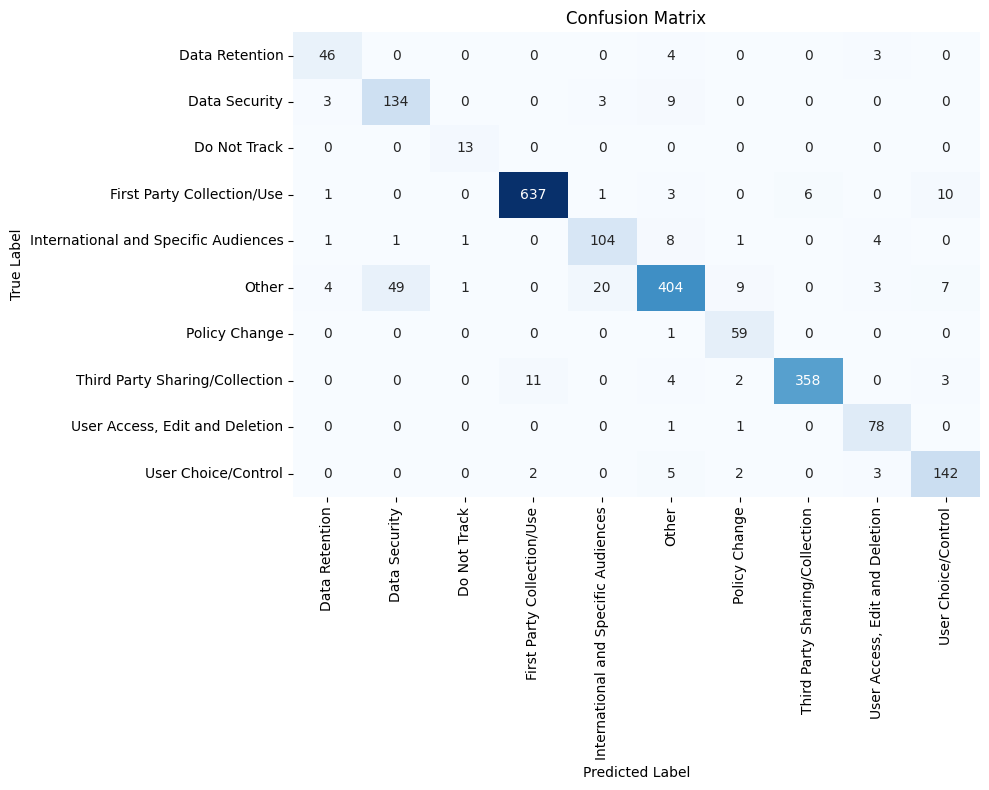

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def show_results_multiclass(model, features, true_labels, classes):
    prob_predictions = model.predict(features)

    yhat_val = np.argmax(prob_predictions, axis=1)

    print(classification_report(true_labels, yhat_val, target_names=classes, zero_division=1))

    conf_matrix = confusion_matrix(true_labels, yhat_val)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=False,
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

show_results_multiclass(legalbert_model,
                        [test_encodings['input_ids'], test_encodings['attention_mask']],
                        test_labels,
                        target_names)


In [2]:
def analyze_privacy_policy(policy_text, model, tokenizer, target_names, chunk_size=500, overlap=50):
    """
    Analyze a privacy policy text using the trained classifier

    Args:
        policy_text (str): Full privacy policy text
        model: Trained LegalBERT model
        tokenizer: LegalBERT tokenizer
        target_names (list): List of category names
        chunk_size (int): Maximum size of each text chunk
        overlap (int): Number of characters to overlap between chunks

    Returns:
        list: List of tuples containing (text_chunk, predicted_category, confidence_score)
    """
    # Split into chunks (with some overlap to avoid cutting sentences)
    chunks = []
    start = 0
    while start < len(policy_text):
        end = min(start + chunk_size, len(policy_text))
        # Try to find a sentence boundary
        if end < len(policy_text):
            # Look for next period, question mark, or exclamation point
            for punct in ['. ', '? ', '! ']:
                next_period = policy_text[start:end].rfind(punct)
                if next_period != -1:
                    end = start + next_period + 1
                    break

        chunks.append(policy_text[start:end].strip())
        start = end - overlap

    results = []

    # Analyze each chunk
    for chunk in chunks:
        # Tokenize
        inputs = tokenizer(
            chunk,
            truncation=True,
            padding='max_length',
            max_length=300,
            return_tensors='tf'
        )

        # Get prediction
        prediction = model.predict({
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']
        })

        # Get predicted class and confidence
        pred_class = prediction.argmax(axis=1)[0]
        confidence = prediction[0][pred_class]

        results.append({
            'text': chunk,
            'category': target_names[pred_class],
            'confidence': float(confidence),
        })

    return results

def print_analysis_results(results):
    """
    Print the analysis results in a readable format
    """
    print("\nPrivacy Policy Analysis Results:\n")

    # Print each chunk's classification
    for i, result in enumerate(results, 1):
        print(f"\nChunk {i}:")
        print("-" * 80)
        print(f"Text: {result['text'][:200]}..." if len(result['text']) > 200 else f"Text: {result['text']}")
        print(f"Category: {result['category']}")
        print(f"Confidence: {result['confidence']:.2%}")

    # Print summary statistics
    print("\nSummary:")
    print("-" * 80)
    category_counts = {}
    for result in results:
        category_counts[result['category']] = category_counts.get(result['category'], 0) + 1

    for category, count in sorted(category_counts.items()):
        print(f"{category}: {count} chunks ({count/len(results):.1%})")

In [38]:
test_segments = [
    """We take the security of our data seriously. We use administrative, technical, and physical security designed to safeguard personal data in our possession, and we maintain internal policies and procedures to address our data security. We have been audited and received a SOC 2 report addressing the security of our Services. However, we cannot guarantee the security of the data that we collect and store. We will notify relevant supervisory authorities and data subjects in the event of a data breach, if required under applicable law.""",

    """We may share your personal data with third parties who we partner with for advertising purposes. We also share certain Shopper data with our Merchants, for example, in cases of suspected fraud or in connection with an ongoing investigation.""",

    """If you do not wish to receive marketing communications from us or participate in our ad customization programs, you can simply click the "unsubscribe" link at the bottom of an email you receive from us or you can send an email to marketing@bitpay.com.""",

    """In principle, we do not store your personal data any longer than is strictly necessary for processing purposes. We have a retention policy to ensure that your personal data is retained and deleted in accordance with applicable retention periods. Because we are a regulated financial institution in the United States, we retain personal data collected as a part of our customer due diligence and identification program, as required by applicable federal and state regulations."""
]

print("\nMultiple Segments Analysis:")
print("-" * 80)

for segment in test_segments:
    # Tokenize
    test_encoding = legalbert_tokenizer(
        segment,
        truncation=True,
        padding='max_length',
        max_length=300,
        return_tensors='tf'
    )

    # Get prediction
    prediction = legalbert_model.predict({
        'input_ids': test_encoding['input_ids'],
        'attention_mask': test_encoding['attention_mask']
    })

    # Get predicted class and confidence
    pred_class = prediction.argmax(axis=1)[0]
    confidence = prediction[0][pred_class]

    print("\nSegment Analysis:")
    print(f"Text: {segment}")
    print(f"Predicted Category: {target_names[pred_class]}")
    print(f"Confidence: {confidence:.2%}")
    print("-" * 80)


Multiple Segments Analysis:
--------------------------------------------------------------------------------
1/1 [==============================] - 3s 3s/step

Segment Analysis:
Text: We take the security of our data seriously. We use administrative, technical, and physical security designed to safeguard personal data in our possession, and we maintain internal policies and procedures to address our data security. We have been audited and received a SOC 2 report addressing the security of our Services. However, we cannot guarantee the security of the data that we collect and store. We will notify relevant supervisory authorities and data subjects in the event of a data breach, if required under applicable law.
Predicted Category: Data Security
Confidence: 99.64%
--------------------------------------------------------------------------------
1/1 [==============================] - 0s 70ms/step

Segment Analysis:
Text: We may share your personal data with third parties who we partner wi

In [3]:
bitpay_policy = """Privacy Notice | BitPay
For Individuals
For Businesses
For Individuals
For Businesses
Developers
Help
For Individuals
Buy Crypto
Buy Bitcoin (BTC)
Buy Ether (ETH)
Buy Litecoin (LTC)
Buy Bitcoin Cash (BCH)
Buy Dogecoin (DOGE)
Buy USD Coin (USDC)
Buy 60+ cryptocurrencies
Sell Crypto
Sell Bitcoin (BTC)
Sell Ether (ETH)
Sell Litecoin (LTC)
Sell Bitcoin Cash (BCH)
Sell Dogecoin (DOGE)
Sell USD Coin (USDC)
Sell 60+ cryptocurrencies
Store Crypto
BitPay Wallet
Bitcoin Wallet
Ethereum Wallet
Tether Wallet
Polygon Wallet
Litecoin Wallet
Pay with Crypto
Debit Card
Merchant Directory
Buy Gift Cards
Browser Extension
Bill Pay
Learn
Blog
Crypto Stats
For Businesses
Accept Crypto
Online Payments
Billing
Retail
Send Crypto
Crypto Payroll
Customer Rewards & Rebates
Marketplace & Affiliates
Use Cases
NFTs
Nonprofits
Resources
Articles
Crypto Stats
Developers
Help
Log In
Privacy Notice
EU Privacy Notice
Cookie Policy
Exercise Your Rights
Manage Cookies
EU Privacy Notice
Privacy Notice
EU Privacy Notice
Exercise Your Rights
Manage Cookies
EU Privacy Notice Updated May 19, 2020
Scope
Responsibility
What is "personal data"?
How we obtain personal data
Who are the data subjects?
Details of data processing
How we protect and store personal information
Data retention
How we share personal data with third parties and transfers outside the EEA
Your rights
Marketing
Contact Information Scope
This EU Privacy Notice (“Notice”) describes the ways BitPay Inc. (“BitPay”, “we”, “us”, “our”) collects,
stores, uses and protects
personal data. BitPay’s services include Merchant processing services, websites, mobile applications,
products, and other features, technologies or functionalities, including customer support (the
“Services”) offered by us. This Notice applies to all processing of personal data on the website
www.bitpay.com
and all other BitPay sites on which it appears (the “Sites”).
The purpose of this Notice is to inform you about the processing of personal data by us and to inform
you of your rights.
Responsibility Compliant processing. BitPay complies with applicable United States
federal and state regulations and
European Economic Area (European Union + Norway, Iceland, Liechtenstein) (hereinafter “EEA”) data
protection laws, such as the General Data Protection Regulation and its implementation acts (hereinafter
“GDPR”).
BitPay as a controller. BitPay is considered the controller
for processing personal data as described in this Notice.
BitPay as a processor. In principle, we control the processing of your
personal data. However, in some cases, we may process your personal data on behalf of another party, who
is the controller responsible for your personal data. This Notice does not relate to that part of our
processing activities where we are acting on behalf of another controller. For such processing, the
privacy notice of the relevant controller applies, and we encourage you to read that notice.
Third party websites. The Sites may include links to websites of third
parties (for example, hyperlinks, banners or buttons). We are not responsible for the content of those
websites, services provided by those third parties, or their compliance with applicable privacy
legislation.
What is “personal data”?
Personal data is any information relating to an identified natural person or that can be used to
identify a natural person directly or indirectly. A prime example of identifiable information is a
person’s legal full name.
How we obtain personal data Means of collection. We obtain your personal data in various ways:
Provided by you. We obtain information provided by you, for example,
if you contact us, sign up for our newsletter, or provide information to us in the course of using our
Services. When you provide personal data to BitPay, please do not provide information that is
irrelevant, inaccurate, and/or unnecessary for the provision of Services.
Automatically collected. We obtain some information automatically
when you visit our Sites, for example, via cookies. For more information, please see our
Cookie Policy.
Third parties. We may obtain information from third parties, such as
our Merchants with which you do business.
Required provision. It may be that providing certain personal data to
us is a statutory or contractual requirement, a requirement necessary to enter into a contract, or that
you are otherwise obliged to provide. If that is the case, we will inform you thereof and will explain
the possible consequences if you fail to provide such personal data to us.
Who are the data subjects?
There are several types of data subjects whose personal data we process:
Visitors of our Sites;
Merchants who sign up for our Services (“Merchants” means any business that uses our Services to
process payments, including non-profits that use our Services to accept donations and “Aggregators”
that use our Services as a payment services platform for their own Merchants);
Shoppers of Merchants (“Shoppers” means individuals who indirectly interface with BitPay when paying a
Merchant’s invoice that is forwarded by BitPay to a Merchant during checkout, when requesting a refund
from a Merchant, when creating a BitPay account, or when making a donation to a non-profit);
BitPay wallet holders who have downloaded and installed the BitPay app on their mobile device;
Payees (e.g., employees, contractors, vendors or exchange customers) who request a payment (“Payout”)
via cryptocurrency from a Merchant and create a BitPay account; and
Partner employees (employees and other agents of our customers and vendors, including potential and
former customers and vendors).
Details of data processing: What kind of personal data do we collect, why, and on what legal
basis? The categories of personal data we collect, the purposes, and the legal bases are set forth below. Our
primary purpose for collecting personal data is to provide you with a secure, smooth, efficient, and
customized experience. We use your personal data to: Provide our Services (including customer support);
Process transactions and send notices about your transactions;
Resolve disputes, collect fees, and troubleshoot problems; Communicate with you about our Services and business and to inform you of matters
that are important for your account and/or use of the Sites. We also use your personal data to respond
to any questions, comments or requests you filed with us and the handling of any complaints;
Comply with applicable laws and regulations;
Establish, exercise and defend legal claims; Monitor and report compliance issues;
Customize, measure, and improve our business, the Services, and the content and
layout of our website and applications (including developing new products and services; managing our
communications; determining the effectiveness of our sales, marketing and advertising; analyzing and
enhancing our products, services, websites and apps; ensuring the security of our networks and
information systems; performing accounting, auditing, invoicing, reconciliation and collection
activities; and improving and maintaining the quality of our customer services);
Perform data analysis; Deliver targeted marketing, service update notices, and promotional offers based on
your communication preferences, and measure the effectiveness of it. To approach you via email for
marketing purposes, we request your consent, unless it is not required by law. You always have the
option to unsubscribe from our mailings, e.g., via the unsubscribe link in our newsletter;
Perform risk management, including comparing information for accuracy and verify it
with third parties and protect against, identify and prevent fraud and other prohibited or illegal
activity, claims and other liabilities; and
Enforce our contractual terms. We only use your personal data where we have a legal basis to do so: Consent. For some processing activities, we require your prior consent. This applies
for example to some of our direct marketing activities which fall under the scope of the GDPR and
ePrivacy rules. You may withdraw your consent at any time (see below).
Performance of a contract. Some personal data we process about you is for the
performance of a contract to which you are a party or in order to take steps at your request prior to
entering into a contract with us.
Legal obligation. In some cases, we have to process your personal data to comply with
legal obligations, including those applicable to financial services institutions, such as under the
Bank Secrecy Act and other anti-money laundering laws.
Legitimate interest. In most cases where we process personal data in the context of
our Services we rely on our legitimate interests in conducting our normal business as an online
payments company as a legal basis for such processing.
Where we process personal data relating to criminal convictions and offenses, we will ensure that we
have a lawful basis to do so. The following sections provide you with some more information.
1. Visitors of Our Sites
Categories of personal data: We may collect the following
personal data of Visitors of our Sites:
Technical information, including IP address; the type of browser, devices and operating systems
you use; identifiers associated with the device(s) you use to access our Sites; the pages you
visit and the features you use; access dates and times; and if you navigated from or navigate to
another website, the address of that website; and information regarding your internet service
provider
Email address (e.g., when you subscribe to our blog or opt in to receive other marketing
materials)
Phone number (e.g., when you contact our sales or media team or opt in to our media list)
Full name (e.g., when you submit a support request)
Country
Cookies: For more information about our use of cookies, please
see our
Cookie Policy.
Collection of personal data: Your personal data is collected by
us when you:
request a BitPay newsletter or content using one of our web forms;
register on the Sites; and
otherwise use the Sites
2. Merchants (including businesses such as nonprofits and Aggregators)
Categories of personal data: We may collect the following
personal data of the beneficial owner or
any user that is added to an account of a Merchant (including nonprofits and Aggregators that use
our Services as a payment services platform for their own Merchants). In the case of Aggregators,
we may collect the personal data of that Aggregator’s Merchants. The elements we collect depend on
our compliance analysis and your risk profile.
Full name of beneficial owner Full names of authorized users Merchant email address (business domain preferred but non-business domain accepted) Full physical address (no post office boxes) Business phone number ID of beneficial owner and authorized user(s) Tax ID (if applicable in specific country) Proof of business Proof of address, if not evident in above documents 3 most recent bank statements or bank letter of good standing Bank account details Collection of personal data: Your personal data is collected by
us when you register for a
Merchant account. We may also obtain information about our Merchants from third parties that
provide identity verification and fraud prevention services, and from relevant Aggregators.
3. Shoppers of Merchants
Categories of personal data: We may collect the following
personal data when you as a Shopper indirectly interface with BitPay when you pay a Merchant’s
invoice, request a refund and/or make donations.
When you pay a BitPay invoice, we collect: Technical information including IP addresses used to view the BitPay invoice; the type of
browser, devices and operating systems you use; identifiers associated with the device(s)
you use to access our sites; the pages you visit and the features you use; access dates and
times; and if you navigated from or navigate to another website, the address of that
website; and information regarding your internet service provider
Products purchased and price at the relevant Merchant Email address Crypto wallet address When you request a refund, we collect: Amount Currency Email address Crypto wallet address Invoice ID When you make a donation, we may collect, depending on the circumstances: Amount Currency Email address Full name Address Phone number Employer Job title City of employment Certain Shoppers may choose to or may be required to create a BitPay account. When you create a BitPay account, we may collect additional information from you. Collection of personal data for invoices: Your personal data is
collected by us either as provided by the Merchant or as manually entered by you. This is
necessary for invoicing, enables us to comply with financial regulations, and creates a more
seamless payment experience for both the Merchant and the Shopper. It also enables us to send an
email to a Shopper to obtain a cryptocurrency refund address in case of a payment exception (e.g.,
overpayments, underpayments, etc.).
Collection of personal data for refunds: A Merchant has the
option to claim a refund via its own BitPay dashboard in case of a payment exception (e.g.,
overpayments, underpayments, etc.). You receive a special link to your email address with
instructions to claim a refund. You have to reach out to the Merchant by email and provide your
personal data.
Collection of personal data for donations: A Merchant collects
data from the donation page on the Merchant’s website (created by the Merchant within its own
dashboard).
4. BitPay Wallet Holders
Categories of personal data: We collect the following personal
data when you create a BitPay non-custodial wallet via the BitPay app:
Email address Wallet name Copayer name Wallet public key Wallet extended public key Wallet coin Wallet multi-sig setup Transaction details Type of phone, OS and version, App version, IP address Wallet ID (Client ID) App Token API Authentication Token Collection of personal data: Your personal data is collected by
us when you enter it into the BitPay App.
5. Payees of Merchants
Categories of personal data: When you as a Payee request or
receive a cryptocurrency payment from a Merchant using the Services, you must create a BitPay
account. We will process the following personal data in order to provide you with a Payout:
Name Email address Walled address/provider Identification documents (such as a passport or a driver's license) Proof of address document (such as a bank statement or a utility bill) Collection of personal data: The Merchant will confirm your
BitPay wallet address so that you can receive the Payout.
6. Employees of Partners
Categories of personal data: We process data about former,
existing and prospective vendors and customers, including Merchants (together, “Partners”). This
includes limited personal data about employees and agents of such Partners (“Partner Employees”)
at the beginning and throughout the course of the Partner relationships. We may process:
Professional contact information (e.g., name, postal address, email address, fax number, phone
number, mobile phone number)
Professional information (e.g., profession and title, place of work, and relationship to our
Partner)
Collection of personal data: We may collect personal data from
you, your employer or colleagues. In very limited cases, it may be a contractual requirement for
us to collect such personal data from Partner Employees (for example, because the Partner Employee
is a designated “point of contact” and if this information is not collected, it could result in a
breach of contract by us or the Partner.)
Specification of legitimate interests. Prior to processing your
personal data on the basis of legitimate interests, we have assessed whether our legitimate business
interests are not overridden by your rights and freedoms. You can contact us for information about the
‘balancing test’ that we conducted to rely on this legal basis. Please find our contact details below.
How we protect and store personal information
We take the security of our data seriously. We use administrative, technical, and physical security
designed to safeguard personal data in our possession, and we maintain internal policies and procedures
to address our data security. We have been audited and received a SOC 2 report addressing the security
of our Services. However, we cannot guarantee the security of the data
that we collect and store. We will notify relevant supervisory authorities and data subjects in the
event of a data breach, if required under applicable law.
Data retention
In principle, we do not store your personal data any longer than is strictly necessary for processing
purposes. We have a retention policy to ensure that your personal data is retained and deleted in
accordance with applicable retention periods. Because we are a regulated financial institution in the
United States, we retain personal data collected as a part of our customer due diligence and
identification program, as required by applicable federal and state regulations.
For further information on our data retention policy, please find our contact details below.
How we share personal data with third parties and transfers outside the EEA Third parties. We may share your personal data with the following third
parties:
Other BitPay entities, including to help detect and prevent potentially illegal acts and violations
of our policies, and to guide decisions about our products, services and communications;
Service providers who help with our business operations and to deliver our Services, such as:
Cloud service providers providing cloud infrastructure; Providers of ID verification solutions and other due diligence solutions (such as KYC and
anti-money laundering);
Providers of website analytics; Providers of customer service solutions outside of the EEA; Providers of marketing automation platforms in the United States
Law enforcement, government officials, regulatory agencies, our banks, and other third parties
pursuant to a
subpoena, court order or other legal process or requirement if applicable to BitPay; or when we
believe, in our sole discretion, that the disclosure of data is necessary to report suspected illegal
or fraudulent activity or to investigate violations of our Terms of Use; and
We may also share certain Shopper data with our Merchants, for example, in cases of suspected fraud or
in connection with an ongoing investigation.
Transfers outside the EEA. BitPay is primarily located in the United
States, and some of the third parties mentioned above may be located in the United States or other
countries outside the EEA. We employ the following safeguards if the
processing of personal data by us qualifies as a transfer of personal data outside the EEA and falls
within the scope of the GDPR:
We may transfer your personal data to countries that have been found to provide an adequate level of
protection of personal data
We may use specific contracts, including Standard Contractual Clauses. For example, we offer Standard
Contractual Clauses to meet data transfer requirements in respect of third parties such as service
providers
You can obtain a copy of such contracts or information about countries in which we have service
providers by contacting us. Please find our contact details below.
Your rights
Under the GDPR and relevant implementation acts, individuals have statutory rights related to their
personal data. For more information on your rights, please refer to
this web page
of the European Commission. Please note that rights are not absolute and may be subject to
conditions.
One key right is the Right to object. You have the right to object to processing of
your personal data
where we are relying on legitimate interests as our legal basis (see above). Under certain
circumstances, we may have compelling legitimate grounds that allow us to continue processing your
personal data. Insofar as the processing of your personal data takes place for direct marketing
purposes, including profiling for direct marketing, we will always honor your request.
Other rights are as follows: Right to withdraw consent. Insofar as our processing of your personal data is based
on your consent (see above), you have the right to withdraw consent at any time.
Right of access. You have the right to request access to your personal data.
Right to rectification. You have the right to request rectification of the personal
data that we hold about you.
Right to erasure. You have the right to request erasure of your personal data. This
enables you to ask us to delete or remove personal data in certain circumstances.
Right to restriction. You have the right to request restriction of processing of your
personal data.
Right to data portability. In some cases, you have the right to request to transfer
your personal data to you or to a third party of your choice.
How to exercise your rights. The exercise of the aforementioned rights
is free of charge and can be
carried out by visiting our
Data Subject Rights Portal.
(You can also contact us by email via the contact details below, but you will receive a reply
email directing you to our Data Subject Rights
Portal so it is easier to go straight to our portal).
Merchants can review and edit their personal data by logging into their account and reviewing their
personal data under the Settings tab on their Merchant dashboard. If you wish to change information
relating to your industry or company website, or if you wish to close your account, you can submit a
request at
https://support.bitpay.com.
If you choose to close your BitPay account, we will
mark your account in our database as "closed". We will retain the information in the account in
accordance with the record retention principles outlined in this Privacy Notice and as required by
applicable law.
Marketing
If you do not wish to receive marketing communications from us or participate in our ad customization
programs, you can simply click the “unsubscribe” link at the bottom of an email you receive from us or
you can send an email to marketing@bitpay.com.
Contact Information Contact DPO. BitPay has appointed a Data Protection Officer. You may
contact us with questions or concerns about our privacy policies or practices at dpo@bitpay.com.
However, If you wish to submit a data privacy rights request, you may do so by visiting our
Data Subject Rights Portal.
Complaints. Subject to applicable law, you also have the right to lodge
a complaint with your local Data
Protection Authority. If you believe we maintain your personal data within the scope of the GDPR, and if
you believe we did not take action in respect of your data subject rights (as set out above) or you are
not satisfied with the way in which we have handled your request, you may lodge a complaint with a
supervisory authority or seek a judicial remedy. The Dutch Data Protection Authority (Autoriteit
Persoonsgegevens) is BitPay’s lead supervisory authority in the EU.
However, we would always appreciate the chance to address your concerns before you approach the
supervisory authority, so please contact our Data Protection Officer with questions or concerns by
sending an email to dpo@bitpay.com or mail to: BitPay B.V., the
representative of BitPay Inc. in the EU:
BitPay B.V.
Stadsplateau 7 WTC office 7
3521 AZ
Utrecht
Netherlands
Phone +44 808 169 7186 We're here to help
Support is just a few taps away. Get your questions answered by using our help library.
Get help
For Businesses Online Crypto Payments Email Billing
Crypto Payouts In-store Payments Crypto Donations NFTs Exchange Rates Business FAQs Pricing Resources For Individuals Crypto Debit Card Crypto Wallet Browser Extension Spend Crypto Merchant Directory Buy Gift Cards Buy Crypto Bill Pay Blog Support Help Developers Integrations Bitcore Insight Open Source PGP Keys Status Company Careers Press BitPay Brand Guide Stats Legal Privacy Complaints Manage Cookies Do Not Sell My Personal Information under CCPA Accessibility Statement
NMLS ID#1496848 BitPay is licensed to engage in Virtual Currency Business Activity by the New York State Department of Financial Services.
Subscribe to BitPay
Subscribe
By submitting this form, you agree to receive marketing and other communications
from BitPay about BitPay products and other company updates. You can unsubscribe from these communications at any time. For more information on our privacy practices, please review our
Privacy Policy.
For Businesses
Online Crypto Payments Email Billing
Crypto Payouts In-store Payments Crypto Donations NFTs Exchange Rates Business FAQs Pricing Resources
For Individuals
Crypto Debit Card Crypto Wallet Browser Extension Spend Crypto Merchant Directory Buy Gift Cards Buy Crypto Bill Pay Blog Support Help
Developers
Integrations Bitcore Insight Open Source PGP Keys Status
Company
Careers Press BitPay Brand Guide Stats Legal Privacy Complaints Manage Cookies Do Not Sell My Personal Information under CCPA Accessibility Statement
NMLS ID#1496848 BitPay is licensed to engage in Virtual Currency Business Activity by the New York State Department of Financial Services.
Subscribe to BitPay
Subscribe
By submitting this form, you agree to receive marketing and other communications
from BitPay about BitPay products and other company updates. You can unsubscribe from these communications at any time. For more information on our privacy practices, please review our
Privacy Policy."""

# Use the existing analyze_privacy_policy function we created earlier
results = analyze_privacy_policy(bitpay_policy, legalbert_model, legalbert_tokenizer, target_names)
print_analysis_results(results)

NameError: name 'legalbert_model' is not defined

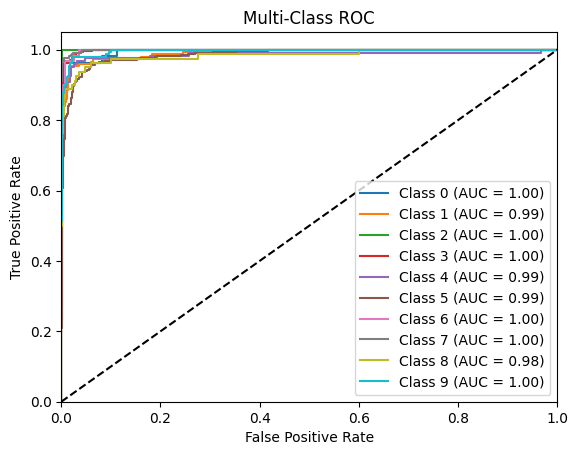

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_true_bin = label_binarize(val_labels, classes=np.arange(num_cat))

for i in range(num_cat):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC')
plt.legend(loc='lower right')
plt.show()


In [ ]:
legalbert_model.save(path + 'legalbert_finetuned_model')


NameError: name 'legalbert_model' is not defined

In [ ]:
from keras.layers import TFSMLayer

loaded_model = TFSMLayer(path + 'legalbert_finetuned_model', call_endpoint='serving_default')


OSError: SavedModel file does not exist at: /content/drive/MyDrive/compliance/OPP-115/legalbert_finetuned_model/{saved_model.pbtxt|saved_model.pb}

In [ ]:
import tensorflow as tf

loaded_model = tf.saved_model.load(path + 'legalbert_finetuned_model')

random_policy_text = "We may share your personal information with third-party service providers to facilitate our services, including payment processing, data analysis, email delivery, hosting services, customer service, and marketing. These third parties are authorized to use your personal information only as necessary to provide these services to us and are required to maintain the confidentiality and security of your information. We do not sell your personal information to any third parties."

random_policy_encoding = legalbert_tokenizer(
    random_policy_text,
    truncation=True,
    padding='max_length',
    max_length=300,
    return_tensors='tf'
)

input_ids = random_policy_encoding['input_ids']
attention_mask = random_policy_encoding['attention_mask']

predicted_probabilities = loaded_model.signatures['serving_default'](
    input_ids=tf.constant(input_ids),
    attention_mask=tf.constant(attention_mask)
)

predicted_class = tf.argmax(predicted_probabilities['dense'], axis=1)

print(f"Predicted category: {target_names[predicted_class[0]]}")


Predicted category: Data Security


In [ ]:
print(list(loaded_model.signatures['serving_default'].structured_outputs.keys()))


['dense']


In [ ]:
pd.set_option('display.max_colwidth', None)

test_df[['policy_chunk', 'policy_category']].head(5)


,policy_chunk,policy_category
0,update Account certain information,"User Access, Edit and Deletion"
1,"null null We use information null non-personally identifiable information in aggregate form null null to build higher quality, more useful Services by performing statistical analyses of the collective characteristics and behavior of the users of the Services, and by measuring demographics and interests regarding specific areas and features of the Services.",First Party Collection/Use
2,"Your California privacy rights. California law permits users who are California residents to request and obtain from us once a year, free of charge, a list of the third parties to whom we have disclosed their personal information (if any) for their direct marketing purposes in the prior calendar year, as well as the type of personal information disclosed to those parties. If you are a California resident and would like to request this information, please submit your request in an email to privacy@tribune.com.",International and Specific Audiences
3,"Even if the registered user chooses to opt-out of receiving e-mails from both MediaNews and third parties, MediaNews reserves the right to contact a registered user regarding account status, changes to this policy, the terms of use, license agreements and other matters relevant to the use of the MediaNews Web sites, services or software provided through the Web sites and/or the information collected.",Other
4,"you can simply ""opt out information to be collected null Not selected personal information",User Choice/Control
